### Calculate wind stress energy into the domain and kinetic energy - barotropic run

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., :-1, :], v[..., :-1]

def unstagger_w(wgrid):
    """ Interpolate w to values at vetical grid cell centres.
    The shape of the returned array is 1 less than that of
    the input array yin the z dimension
    :arg wgrid: w velocity component values with axes (z,...)
    :type wgrid: :py:class:`numpy.ndarray`
    :returns w: w component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    w = np.add(wgrid[:-1, ...], wgrid[1:, ...]) / 2
    return w

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/02_SVB_barotropic_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/02_noSVB_barotropic/'

levels = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 
          73, 78, 83, 88, 93, 98,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels,  chunks=None)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels, chunks=None)

In [4]:
nx = 512
ny = 612
nz = 76
nt = 720
dt = 600 # sec
z1 = 26 # Zl[26] = -101.750 m
z2 = 38 # Zl[38] = -202.200 m
z3 = 46 # Zl[46] = -300.2 m
z4 = 55 # Zl[55] = -495.700 m

depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
masknoSVB = np.ma.getmask(hfac)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

### Energy from wind

Eg. intro in https://www.sciencedirect.com/science/article/pii/S0967063708001994 or
https://journals.ametsoc.org/view/journals/phoc/36/2/jpo2842.1.xml

Wind power input per unit area

$$P =\vec{u_s}\cdot\vec{\tau},$$
where $\vec{u_s}$ is the surface velocity and $\vec{\tau}$ is the wind stress (these should probably be 3D quantities $(u,v,w)$ and ($\tau_x$,$\tau_y$,Pressure?), but let's just use the horizontal components).

Then, an integral of P over area gives a flux of energy in J/s.

Do I have surface velocities?

In [5]:
print('%1.3f' %ds.Z.data[0])

-1.000


I have vel at 1 m depth. 

In [6]:
## Make wind stress array

## Gaussian pulse
t = np.linspace(0,nt*0.167,nt) # time array of wind records
max_tau = 0.1 # W/m^2
sigma = 1
center = 3.5 # base 3.5 hr, faster 2.5 hr, slower 4.5
gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
mask = t>center
gauss[mask]=0

## Rotation angle (in deg) to get alongshore winds (see previous notebook)
angle_up = 300. # upwelling favourable

## domain size
lat_bot = 27.0 
lat_top = 35.3 

## Region where winds will blow (over SVB: 27.9, 30.0, -115.1, -114)
lat1 = 27.0 
lat2 = 35.3 
lon1 = -122 # -122 domain 5
lon2 = -114

## Domain boundaries
lon_ini = -122.0 # -122.0 domain 5
lon_end = -114.0
lat_ini = 27.0
lat_end = 35.3    
    
### Rotate winds
windstress= np.expand_dims(np.expand_dims(gauss,1),1) + np.zeros((nt,ny,nx))
alpha = np.radians(angle_up)

zonal_tau = windstress*np.cos(alpha)
merid_tau = windstress*np.sin(alpha)

(0.0, 20.0)

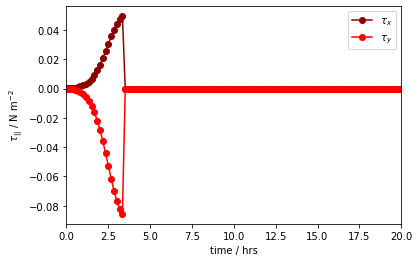

In [7]:
plt.plot(t,zonal_tau[:,0,0],'-o', color='darkred', label=r'$\tau_x$')
plt.plot(t,merid_tau[:,0,0],'-o', color='red', label=r'$\tau_y$')
plt.legend()
plt.xlabel('time / hrs')
plt.ylabel(r'$\tau_{||}$ / N m$^{-2}$')
plt.xlim(0,20)

In [8]:
# Calculate P = \vec{u}\cdot\vec{\tau}

# unstagger first
UU,VV = unstagger(ds.UVEL.data[:,0,...],ds.VVEL.data[:,0,...])
P = UU*zonal_tau[:,:ny-1,:nx-1] + VV*merid_tau[:,:ny-1,:nx-1]

# No SVB
UUnoSVB,VVnoSVB = unstagger(ds2.UVEL.data[:,0,...],ds2.VVEL.data[:,0,...])
PnoSVB = UUnoSVB*zonal_tau[:,:ny-1,:nx-1] + VVnoSVB*merid_tau[:,:ny-1,:nx-1]

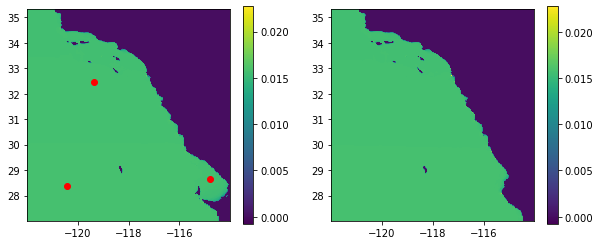

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
pc = ax1.pcolormesh(lon,lat,P[20,:,:])
plt.colorbar(pc,ax=ax1)
p1 = [100,100]
p2 = [460,120]
p3 = [170,400]
ax1.plot(lon[p1[0]],lat[p1[1]],'ro')
ax1.plot(lon[p2[0]],lat[p2[1]],'ro')
ax1.plot(lon[p3[0]],lat[p3[1]],'ro')
ax1.set_aspect(1)

pc2 = ax2.pcolormesh(lon,lat,PnoSVB[20,:,:])
plt.colorbar(pc2,ax = ax2)
ax2.set_aspect(1)

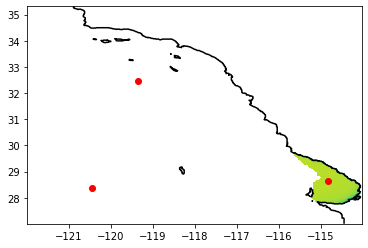

In [10]:
# Select only SVB area: 
# Add an inverse mask of noSVB mask and SVB mask, 
# that way only cells in the bay are not NaN 

onlySVB = ~masknoSVB+maskSVB

plt.pcolormesh(lon[:nx-1],lat[:ny-1],np.ma.masked_array(P[20,:,:],mask=onlySVB[0,:ny-1,:nx-1]))
plt.contour(lon,lat,depth_bay,levels=[0], colors=['k'])

p1 = [100,100]
p2 = [460,120]
p3 = [170,400]

plt.plot(lon[p1[0]],lat[p1[1]],'ro')
plt.plot(lon[p2[0]],lat[p2[1]],'ro')
plt.plot(lon[p3[0]],lat[p3[1]],'ro')

In [11]:
# Calclulate energy flux in J/s over whole domain (surface integrated)
# rA area tracer cells
# This cell is fast
dA = np.expand_dims(ds.rA.data,0) + np.zeros((nt,ny,nx))
daP = dA[:,:ny-1,:nx-1]*P
Ewind = np.nansum(np.nansum(daP, axis=1),axis=1)

#No SVB
dAnoSVB = np.expand_dims(ds2.rA.data,0) + np.zeros((nt,ny,nx))
daPnoSVB = dAnoSVB[:,:ny-1,:nx-1]*PnoSVB
EwindnoSVB = np.nansum(np.nansum(daPnoSVB, axis=1),axis=1)

In [24]:
# Calclulate energy flux in J/s over SVB (surface integrated)
# rA area tracer cells
# This cell Takes ages if you try to mask, I am muliplying by mask instead
#daP_SVB = np.ma.masked_array(daP,mask=onlySVB[0,:ny-1,:nx-1])
daP_SVB = daP*(~onlySVB[0,:ny-1,:nx-1])


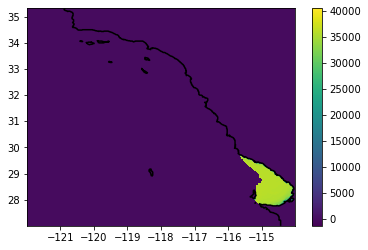

In [25]:
pc = plt.pcolormesh(lon[:nx-1],lat[:ny-1],daP_SVB[20,:,:])
plt.colorbar(pc)
plt.contour(lon,lat,depth_bay,levels=[0], colors=['k'])


In [12]:
# Area of domain with
AREA = np.nansum(np.ma.masked_array(ds.rA.data, mask=maskSVB[0,:,:]))

# Area without SVB
AREA_woSVB = np.nansum(np.ma.masked_array(ds2.rA.data, mask=masknoSVB[0,:,:]))

# Area SVB
AREA_SVB = np.nansum(np.ma.masked_array(ds.rA.data,mask=onlySVB[0,:,:]))

print('Area with SVB: %1.5e m^2' %AREA)
print('Area without SVB: %1.5e m^2' %AREA_woSVB)
print('Area of SVB: %1.5e m^2' %AREA_SVB)

Area with SVB: 4.78733e+11 m^2
Area without SVB: 4.64252e+11 m^2
Area of SVB: 1.46192e+10 m^2


In [18]:
# Volume of domain with
dA = np.expand_dims(ds.rA.data,0) + np.zeros((nz,ny,nx))
drF =  np.expand_dims(np.expand_dims(ds.drF.data,1),1) + np.zeros((nz,ny,nx))

dAnoSVB = np.expand_dims(ds2.rA.data,0) + np.zeros((nz,ny,nx))
drFnoSVB =  np.expand_dims(np.expand_dims(ds2.drF.data,1),1) + np.zeros((nz,ny,nx))

vol = dA * (drF) * hFacCSVB 
VOLUME = np.nansum(np.ma.masked_array(vol, mask=maskSVB))

# Volume without SVB
vol2 = dAnoSVB * (drFnoSVB) * hFacC
VOLUME_woSVB = np.nansum(np.ma.masked_array(vol2, mask=masknoSVB))

print('Vol with SVB: %1.5e m^3' %VOLUME)
print('Vol without SVB: %1.5e m^3' %VOLUME_woSVB)
print('Vol of SVB: %1.5e m^3' %(VOLUME-VOLUME_woSVB))

Vol with SVB: 5.76902e+14 m^3
Vol without SVB: 5.75482e+14 m^3
Vol of SVB: 1.41968e+12 m^3


In [19]:
(5.76902e+14)/5.75482e+14

1.0024674968113685

In [26]:
# This cell takes ages too - I'm selecting only 22 times because I know Ewind is zero after 3.5 hours (21 ntimes)
Ewind_SVB = np.nansum(np.nansum(daP_SVB[:44,], axis=1),axis=1)

In [27]:
#for ee in Ewind[:44]:
#    print('%f' %ee)

In [28]:
#for ee in EwindnoSVB[:44]:
#    print('%f' %ee)

In [29]:
# slow
#for ee in Ewind_SVB[:]:
#    print('%f' %ee)

In [30]:
## Non-zero elements of the array printed above
Ewind_SVB_array = np.array([1967.336140,
                             13658.249842,
                             58381.587749,
                             203059.249746,
                             583040.490311,
                            1605971.282449,
                            4212949.908733,
                            9988163.429514,
                            22737647.608706,
                            49719098.402076,
                            100951667.449054,
                            195337257.246875,
                            361892444.111385,
                            631783365.147192,
                            1047506643.644784,
                            1656420482.996358,
                            2488822890.624424,
                            3552559954.569267,
                            4826334444.561691,
                            6249001678.690140,
                            7481331481.931970,
                            0.000000])

Ewind_noSVB_array =   np.array([1908.242113,
                                13250.440428,
                                56643.048604,
                                197022.699529,
                                565736.516323,
                                1558333.593194,
                                4088052.794804,
                                9692372.395526,
                                22064613.394391,
                                48247946.294462,
                                97966799.420028,
                                189564709.144951,
                                351202565.610907,
                                613133365.634483,
                                1016604312.240177,
                                1607583381.294032,
                                2415491252.341014,
                                3447959452.724622,
                                4684328563.799050,
                                6065263172.112794,
                                7261647121.061090,
                                0.000000])

Ewind_onlySVB_array = np.array([57.999554,
                                399.526290,
                                1701.314444,
                                5902.245192,
                                16903.844723,
                                46522.982646,
                                121952.956161,
                                288711.758155,
                                656842.711860,
                                1435618.962636,
                                2912042.260602,
                                5630858.473472,
                                10426294.092496,
                                18186848.292017,
                                30130501.571881,
                                47611648.716257,
                                71482254.507949,
                                101949005.517322,
                                138389008.463340,
                                179037874.016783,
                                213991926.116055,
                                0.000000
                                ])

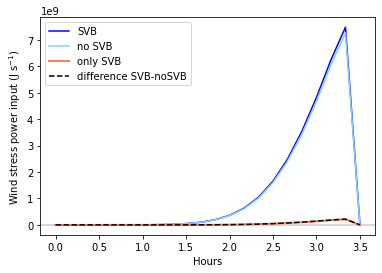

In [31]:
end = 22
fig,ax = plt.subplots(1,1)
ax.axhline(0, color='0.8')
ax.plot(time[:end]/3600,Ewind_SVB_array,color='blue', label='SVB')
ax.plot(time[:end]/3600,Ewind_noSVB_array,color='lightskyblue',label='no SVB')
ax.plot(time[:end]/3600,Ewind_onlySVB_array,color='coral',label='only SVB', linewidth=2)
ax.plot(time[:end]/3600,Ewind_SVB_array-Ewind_noSVB_array,'--',color='k',label='difference SVB-noSVB')
ax.set_ylabel(r'Wind stress power input (J$~$s$^{-1}$)')
ax.set_xlabel('Hours')
ax.legend()